# Newton's Method

In [1]:
using DrWatson;
@quickactivate "MATH361Lectures";
import MATH361Lectures

In [2]:
using Polynomials, Plots, LaTeXStrings
default(markersize=3,linewidth=1.5);

Consider the function $f(x)=x^3 - 1$. We have plotted its graph below:

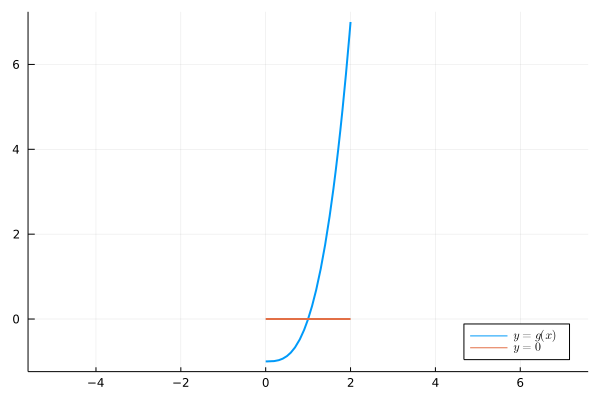

In [3]:
f(x) = x^3 - 1
plt=plot([f,x -> 0],0,2,label=[L"y=g(x)" L"y=0"],aspect_ratio=1,linewidth=2,legend=:bottomright)

We can prove that $f(x)=x^3 - 1$ has a **unique** root in the interval $(0,2)$. For one, we have that 

$$
\begin{align*}
f(0) &= -1 < 0 \\
f(2) &= 7 > 0
\end{align*}
$$

so the intermediate value theorem (IVT) allows us to conclude that $f$ has **at least** one root in $(0,2)$.

Now suppose that $f$ has two roots in $(0,2)$, let's call these assumed roots $r_{1}$ and $r_{2}$ and suppose that $r_{1} < r_{2}$. Then our assumption implies that $f(r_{1})=f(r_{2})=0$. Therefore, Rolle's Theorem implies that there is a number $c\in (r_{1},r_{2})$ such that

$$f'(c) = 3c^2 = 0$$

However, there is no value $x\in (r_{1},r_{2}) \subset (0,2)$ such that $3x^2 = 0$ leading to a contradiction to the assumption that $f$ has multiple roots in $(0,2)$. 

Let's carry out a few Newton iterations to approximate the root of $f(x)=x^3 - 1$. 

In [4]:
f_prime(x) = 3*x^2
F_newton = x -> x - f(x)/f_prime(x);

In [5]:
x = 0.5; 
for k = 1:6
    x = [x;F_newton(x[k])]
end
x

7-element Vector{Float64}:
 0.5
 1.6666666666666667
 1.231111111111111
 1.0406706238357895
 1.0015687495706436
 1.000002455837752
 1.0000000000060312

Now let's make a log plot of the errors.

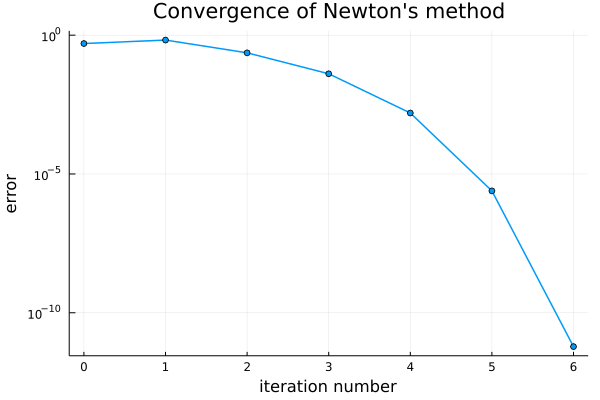

In [6]:
err = @. abs(x-1.0)
plot(0:6,err,m=:o,
    leg=:none,xaxis=("iteration number"),yaxis=("error",:log10),title="Convergence of Newton's method")

Notice that the convergence is **not** linear and appears to be quadratic. We will derive that this is a general characteristic of Newton's Method. 

## Implementing Newton's Method

In order to implement Newton's method, we need to take two important points into consideration:

  - Stopping condition: when do we stop the Newton iterations?
  
  - Function and derivative specification: we need to include $f$ and $f'$ as inputs to the algorithm
  
 The following Julia code implements Newton's method as a function.

In [7]:
function newtons_method(f,f_prime,x0)
    funtol = 100*eps(Float64);
    xtol = 100*eps(Float64);
    maxiter = 40;
    
    x = [];
    y = [];
    dx = Inf;
    k = 1;
    x = push!(x,x0);
    y = f(x0);
    
    while (abs(dx) > xtol) && (abs(y) > funtol) && (k < maxiter)
        dydx = f_prime(x[k]);
        dx = -y/dydx;
        x = push!(x,x[k] + dx);
        
        k = k+1;
        y = f(x[k]);
    end
    
    if k == maxiter
        println("Maximum number of iterations reached.")
    end
    
    return x
    
end

newtons_method (generic function with 1 method)

Let's see an example of using `newtons_method`. 

In [8]:
f(x) = exp(x) - x - 2
f_prime(x) = exp(x) - 1
x0 = 1.0;
xs = newtons_method(f,f_prime,x0)

5-element Vector{Any}:
 1.0
 1.163953413738653
 1.1464211850430086
 1.1461932587044987
 1.1461932206205836

In [9]:
f(xs[end])

1.7763568394002505e-15

There is a powerful Julia package, `NLsolve` that implements Newton's method. Let's see how it is used by aplpying it to  our previous example. 

In [10]:
using NLsolve

In [11]:
function f!(F,x)
    F[1] = exp(x[1]) - x[1] - 2
end

function j!(J,x)
    J[1,1] = exp(x[1]) - 1
end

j! (generic function with 1 method)

In [12]:
nlsolve(f!,j!,[1.0],method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [1.0]
 * Zero: [1.1461932206205836]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

We can even use `Nlsolve` to approximate solutions to systems of nonlinear equations.  

A nonlinear system has the form:

$$
\begin{align*}
    F_{1}(x_{1},x_{2},\ldots , x_{n}) &= 0 \\
    F_{2}(x_{1},x_{2},\ldots , x_{n}) &= 0 \\
     & \vdots \\
    F_{m}(x_{1},x_{2},\ldots , x_{n}) &= 0 
\end{align*}
$$

In order to solve a nonlinear system usign Newton's method, we must compute the derivative of the system. The derivative is a matrix, called the **Jacobian** matrix and is defined as follows: 

$$
J(x_{1},x_{2},\ldots , x_{n}) = \left[\begin{array}{cccc} \frac{\partial F_{1}}{\partial x_{1}} & \frac{\partial F_{1}}{\partial x_{2}} & \cdots & \frac{\partial F_{1}}{\partial x_{n}} \\ \frac{\partial F_{2}}{\partial x_{1}} & \frac{\partial F_{2}}{\partial x_{2}} & \cdots & \frac{\partial F_{2}}{\partial x_{n}} \\ \vdots & \vdots & \cdots & \vdots \\ \frac{\partial F_{m}}{\partial x_{1}} & \frac{\partial F_{m}}{\partial x_{2}} & \cdots & \frac{\partial F_{m}}{\partial x_{n}} \end{array} \right] = \left[ \frac{\partial F_{i}}{\partial x_{j}} \right]_{ij}
$$

Let's see an example. If

$$
\begin{align*}
F_{1}(x_{1},x_{2}) &= x_{1}^{2} + x_{2}^{2} - 1 \\
F_{2}(x_{1},x_{2}) &= 5x_{1}^{2}  + 21x_{2}^{2} - 9
\end{align*}
$$

then the Jacobian is

$$
\begin{align*}
J(x_{1},x_{2}) = \left[\begin{array}{cc} 2x_{1} & 2x_{2} \\ 10x_{1} & 42x_{2}  \end{array} \right]
\end{align*}
$$

Let's apply `nlsolve` to find a solution to this system and then we will develop the mathematical theory necessary to explain what `nlsolve` is doing exactly. 

In [13]:
function f!(F,x)
    F[1] = x[1]^2 + x[2]^2 - 1
    F[2] = 5*x[1]^2 + 21*x[2]^2 - 9
end

function j!(J,x)
    J[1,1] = 2*x[1]
    J[1,2] = 2*x[2]
    J[2,1] = 10*x[1]
    J[2,2] = 42*x[2]
end

j! (generic function with 1 method)

In [14]:
nlsolve(f!,j!,[1.0;0.25],method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [1.0, 0.25]
 * Zero: [0.8660254037844385, 0.5000000000000006]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

Let's confirm that we do hace an approximate solution:

In [15]:
x = 0.866025; y = 0.5;
println(x^2+y^2 - 1)
println(5*x^2+21*y^2-9)

-6.993749999129051e-7
-3.496874999342481e-6


Let's go back to the board to derive our theory. 

Let's carry out a few steps of the multivariable Netwon's method for the system

$$
\begin{align*}
F_{1}(x_{1},x_{2}) &= x_{1}^{2} + x_{2}^{2} - 1 \\
F_{2}(x_{1},x_{2}) &= 5x_{1}^{2}  + 21x_{2}^{2} - 9
\end{align*}
$$

We need to evaluate $F$ and the Jacobian $J$ so let's start by coding functions for both of those.

In [16]:
function F(x)
    return [x[1]^2+x[2]^2-1;5*x[1]^2+21*x[2]^2-9]
end

function J(x)
    return [2*x[1] 2*x[2];10*x[1] 42*x[2]]
end

J (generic function with 1 method)

In [17]:
x0 =  [1.0;0.25]
x1 = x0 - inv(J(x0))*F(x0)
x2 = x1 - inv(J(x1))*F(x1)
x3 = x2 - inv(J(x2))*F(x2)
x4 = x3 - inv(J(x3))*F(x3)
println(x0)
println(x1)
println(x2)
println(x3)
println(x4)

[1.0, 0.25]
[0.875, 0.625]
[0.8660714285714286, 0.5125]
[0.8660254050073638, 0.5001524390243902]
[0.8660254037844386, 0.5000000232305737]


We can assess our root approximation by evaluating the function:

In [18]:
F(x4)

2-element Vector{Float64}:
 2.323057413100571e-8
 4.878420583054321e-7

We see that the result is quite small in magnitude providing evidence that we have a good approximation to a solution to the nonlinear system. 

There are some issues regarding rootfinding that we still need to address. Namely:

  1) What happens in Newton's method if the derivative is zero? 
  2) Newton's method require us to compute the derivative which can be challenging, especially in the multidimensional setting. What can be done when it's inconvenient to provide a derivative for an algorithm? 
  
We will take up these questions in time. Before doing so, it's helpful to first study methods for function approximation and numerical calculus. This is what we will do now. 